In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<font size=4>Past method is more manual and resource consuming; it involved filtering the dates for consecutive seven-day periods, then performing calculations on those groups with a nested for loop.

New method uses .rolling() to gain extract better information more efficiently; instead of weeks, we display a rolling seven-day average.</font>

In [2]:
# read in the raw data
new_cases = pd.read_csv("resources/covid19cases_test.csv")
new_cases

,date,area,area_type,population,cases,cumulative_cases,deaths,cumulative_deaths,total_tests,cumulative_total_tests,positive_tests,cumulative_positive_tests,reported_cases,cumulative_reported_cases,reported_deaths,cumulative_reported_deaths,reported_tests
0,2020-02-01,Alameda,County,1685886.0,3.0,3.0,0.0,0.0,4.0,4,0.0,0,0.0,0.0,0.0,0.0,NaN
1,2020-02-02,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
2,2020-02-03,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
3,2020-02-04,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,0.0,5,0.0,0,0.0,0.0,0.0,0.0,NaN
4,2020-02-05,Alameda,County,1685886.0,0.0,3.0,0.0,0.0,1.0,6,0.0,0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42939,2021-12-31,Yuba,County,79290.0,27.0,10980.0,0.0,74.0,160.0,131849,35.0,12830,0.0,10844.0,0.0,99.0,NaN
42940,2022-01-01,Yuba,County,79290.0,26.0,11006.0,0.0,74.0,93.0,131942,28.0,12858,0.0,10844.0,0.0,99.0,NaN
42941,2022-01-02,Yuba,County,79290.0,29.0,11035.0,0.0,74.0,84.0,132026,32.0,12890,0.0,10844.0,0.0,99.0,NaN
42942,2022-01-03,Yuba,County,79290.0,0.0,11035.0,0.0,74.0,NaN,132026,NaN,12890,193.0,11037.0,0.0,99.0,1213.0


<font size="5">Data Cleaning</font>

In [3]:
# new df with filtered for relevant columns
data = new_cases[["area", "cases", "deaths", "date", "population"]]

# columns renamed
data.columns = ["county", "cases", "deaths", "date", "population"]

# drop rows with nan values
data = data.dropna()

# sort df by the date column, ascending
data = data.sort_values("date")

# create a clean dataframe, filtering out rows that have irrelevant column values
clean_cases = data.loc[ (data["county"] != "Unknown") & (data["county"] != "Out of state")]

# create a list of counties for later iteration
counties = clean_cases["county"].unique().tolist()

In [4]:
clean_cases

,county,cases,deaths,date,population
0,Alameda,3.0,0.0,2020-02-01,1685886.0
28864,San Luis Obispo,0.0,0.0,2020-02-01,278862.0
31680,Santa Cruz,0.0,0.0,2020-02-01,273999.0
10560,Kern,0.0,0.0,2020-02-01,927251.0
33792,Siskiyou,0.0,0.0,2020-02-01,43956.0
...,...,...,...,...,...
702,Alameda,0.0,0.0,2022-01-03,1685886.0
4926,Colusa,0.0,0.0,2022-01-03,22593.0
37310,Sutter,0.0,0.0,2022-01-03,105747.0
39422,Tulare,0.0,0.0,2022-01-03,484423.0


<font size=5>Loop through counties and apply .rolling() and per capita calculations</font>

In [5]:
# create empty dataframe; the new df will contain all calculations
column_names = ["county", "cases", "deaths", "date", "population", "average_cases",
                "cases_per_cap", "average_deaths", "deaths_per_cap"]
weekly_df = pd.DataFrame(columns = column_names)
weekly_df

,county,cases,deaths,date,population,average_cases,cases_per_cap,average_deaths,deaths_per_cap


In [6]:
# loop through counties, apply seven-day rolling window and calculations
# append results to empty dataframe

for county in counties:
    
    # filter dataframe for a given county
    df = clean_cases.loc[clean_cases["county"] == county]
    # reset the index
    df = df.reset_index(drop=True)
    
    # apply .rolling() to create a column of seven-day averages
    df["average_cases"] = df.cases.rolling(window=7).mean()
    # create another new column with per capita calculation applied
    df["cases_per_cap"] = round((df["average_cases"]/df["population"]) * 100000, 3)
    
    # same operations for average deaths and average per capita deaths
    df["average_deaths"] = df.deaths.rolling(window=7).mean()
    df["deaths_per_cap"] = round((df["average_deaths"]/df["population"]) * 100000, 3)
    
    # append temporary dataframe with calculations to our final dataframe
    weekly_df = weekly_df.append(df)
    
# display results
weekly_df

,county,cases,deaths,date,population,average_cases,cases_per_cap,average_deaths,deaths_per_cap
0,Alameda,3.0,0.0,2020-02-01,1685886.0,NaN,NaN,NaN,NaN
1,Alameda,0.0,0.0,2020-02-02,1685886.0,NaN,NaN,NaN,NaN
2,Alameda,0.0,0.0,2020-02-03,1685886.0,NaN,NaN,NaN,NaN
3,Alameda,0.0,0.0,2020-02-04,1685886.0,NaN,NaN,NaN,NaN
4,Alameda,0.0,0.0,2020-02-05,1685886.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
698,California,58997.0,7.0,2021-12-30,40129160.0,45124.571429,112.448,14.142857,0.035
699,California,20439.0,3.0,2021-12-31,40129160.0,45466.142857,113.300,12.142857,0.030
700,California,6495.0,2.0,2022-01-01,40129160.0,45022.285714,112.193,9.857143,0.025
701,California,3214.0,0.0,2022-01-02,40129160.0,41672.714286,103.846,7.428571,0.019


<font size="5">Sample Plot</font>

In [7]:
# store oldest and newest dates
first_date = weekly_df.date[0]
last_date = weekly_df.date.unique().tolist()[-1]

In [8]:
# create function that plots a given county with its rolling average
def county_plot(county):
    county_df = weekly_df.loc[weekly_df.county == county]
    county_df = county_df.fillna(0)
    
    dates = county_df.date.unique().tolist()
    county_cases = county_df.cases.tolist()
    county_cases_rolling = county_df.average_cases.tolist()
    
    plt.figure(figsize=(9,5))
    plt.plot(dates, county_cases, color="grey", alpha=0.5)
    plt.plot(dates, county_cases_rolling, color="red")
    plt.title("Daily Cases: 7-Day Moving Average")
    plt.xlabel("February 1, 2020 - January 3, 2022")
    plt.ylabel("Per 100k")
    plt.xticks(dates[::55], rotation="45")
    plt.show()

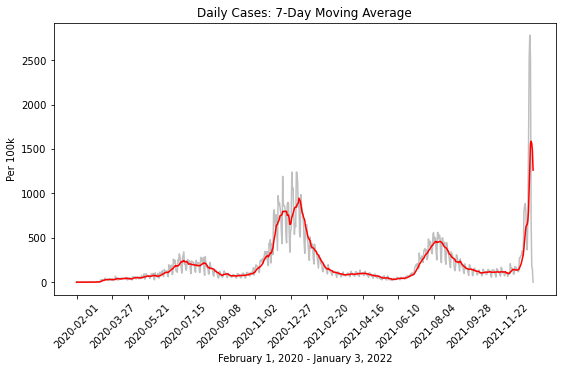

In [9]:
county_plot("Alameda")

<font size="5">Export as TXT, JSON</font>

In [10]:
import os, json, uuid

In [11]:
# use .to_dict and 'records' orient to make our desired list
# can be used as 'data.js', or .insert_many with PyMongo
list_d = weekly_df.to_dict(orient='records')

In [12]:
# write to a text file for our data.js later
with open("rolling_weekly_dict.txt", "w") as file:
    file.write(json.dumps(list_d))

In [13]:
# or, write to json file instead
#weekly_df.to_json('weekly_df.json', orient='records')